In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Report September

**Goal:** Super Resolution of images of turbolence

**data:** An image of a turbolence is the respesentation of the 2D velocity field 
$$\mathbf{u}_t(x,y) = [v_t^{\mathtt{x}}(x,y), v_t^\mathtt{y}(x,y)]$$
of a turbulent flow at the timestemp $t$, where $v_t^{\mathtt{k}}(x,y)$ is the velocity component with respect to the $k$-th component, being $k = \{x,y\}$.

**simplification:** we consider only a single image, that is for a given timestemp $t$. Therefore we consider that the 2D velocity field $\mathbf{u}$ is a (differential) function of the coordinates $\mathbf{x} = [x, y]$

$$\mathbf{u}(\mathbf{x}) = f(\mathbf{x})$$

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# some imports from my project library
from turboflow.dataloaders import load_turbo2D_simple_numpy
from turboflow.utils import phy_utils as phy
from turboflow.utils import dsp_utils as dsp

In [10]:
Xlr, Ulr = load_turbo2D_simple_numpy(ds=4) # ds=downsampling factor
Xhr, Uhr = load_turbo2D_simple_numpy(ds=1) # ds=downsampling factor

Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Y shape (256, 256, 2)
Y min, max: -2.382122 2.999472
after normalization, Y min, max: -0.7941804424245333 1.0


`Xlr` and `ylr` are the low resolution (LR) meshgrid and 2D velocitity field, respectively.

`Xhr` and `yhr` are the high resolution (HR) meshgrid and 2D velocitity field, respectively.

High resolution
HR, Input shape,  Xhr: (65536, 2)
HR, Output shape, Uhr: (65536, 2)
HR img shape: 256

Low resolution
LR Input shape,  Xlr: (4096, 2)
LR Output shape, Ulr: (4096, 2)
LR img shape: 64


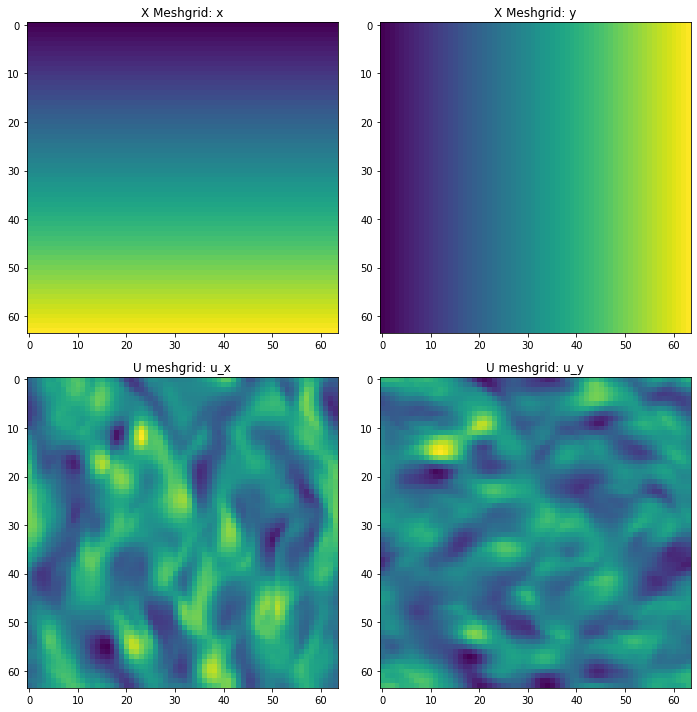

In [11]:
print('High resolution')
print('HR, Input shape,  Xhr:', Xhr.shape) # n_pixels x 2
print('HR, Output shape, Uhr:', Uhr.shape) # n_pixels x 2
H = int(Xhr.shape[0]**0.5)

print('HR img shape:', H)

print('')
print('Low resolution')
print('LR Input shape,  Xlr:', Xlr.shape) # n_pixels x 2
print('LR Output shape, Ulr:', Ulr.shape) # n_pixels x 2
L = int(Xlr.shape[0]**0.5)
print('LR img shape:', L)

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('X Meshgrid: x')
plt.imshow(Xlr.reshape(L,L,2)[:,:,0])
plt.subplot(222)
plt.title('X Meshgrid: y')
plt.imshow(Xlr.reshape(L,L,2)[:,:,1])
plt.subplot(223)
plt.title('U meshgrid: u_x')
plt.imshow(Ulr.reshape(L,L,2)[:,:,0])
plt.subplot(224)
plt.title('U meshgrid: u_y')
plt.imshow(Ulr.reshape(L,L,2)[:,:,1])
plt.tight_layout()
plt.show()

These images are the low resolution of a 2D flow (4 times lower of the the highest resolution).  

## (Single Image) Super Resolution

The goal is to increase the resolution of this images. From a physics perspective, we want to solve the *closure problem* of the given turbulence.

We put ourself in the following case:

- HP1: we dont have access to fully resolved data, that is, we cannot use the HR resolution image for training (for now). Rather, we have access to the LR data on a LR meshgrid.
- HP2: at test time, we want to do off-grid evaluation, that is we want to evalutate the velocity field on a set of new off-grid query points
- HP2.5: we do interpolation: the query points are inside the coarse (=LR) grid.
- HP3: we consider a single timestamp (single image)
- HP4: we have some knowledge of the physical phenemon generating the data (incompressibility constraint, parameters of the Navier-Stokes equation)

## Interpolation based upsampling (baseline 0)

one naive way to increase the resolution of an image is to interpolate the pixel.  
For instance, using a bilinear interpolator

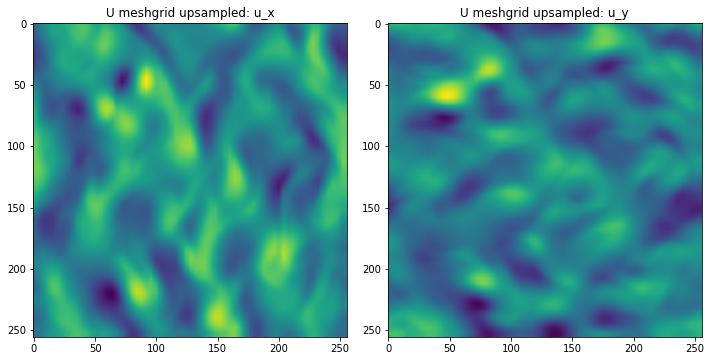

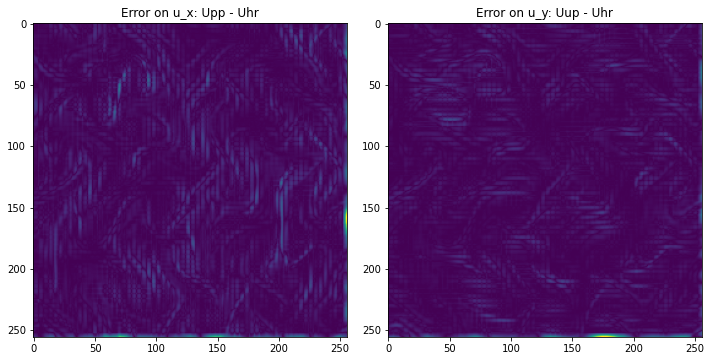

In [12]:
U1up = dsp.interpolate2D_mesh01x01(Xlr.reshape(L,L,2), Ulr[:,0], scale=4)[:,:,None]
U2up = dsp.interpolate2D_mesh01x01(Xlr.reshape(L,L,2), Ulr[:,1], scale=4)[:,:,None]
Uup = np.concatenate([U1up, U2up], axis=-1)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('U meshgrid upsampled: u_x')
plt.imshow(Uup[:,:,0])
plt.subplot(122)
plt.title('U meshgrid upsampled: u_y')
plt.imshow(Uup[:,:,1])
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('Error on u_x: Upp - Uhr')
plt.imshow(np.abs(Uup[:,:,0] - Uhr.reshape(H,H,2)[:,:,0]))
plt.subplot(122)
plt.title('Error on u_y: Uup - Uhr')
plt.imshow(np.abs(Uup[:,:,1] - Uhr.reshape(H,H,2)[:,:,1]))
plt.tight_layout()
plt.show()

In [13]:
error = np.abs(Uup - Uhr.reshape(H,H,2))**2
print(error.sum())

17.267197965463133


The image are nice, but does they respect the instrinsic physical properties of the turbulent flow?  
First the estimated velocity field must respect the constraint: $\nabla \mathbf{u} = 0$

Warning *** CHECK THE GRADIENT DIRECTION


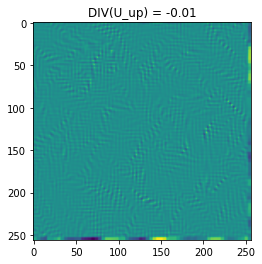

Warning *** CHECK THE GRADIENT DIRECTION


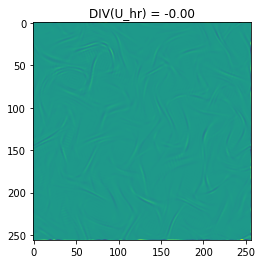

In [14]:
Dup = phy.compute_divergence(Uup[:,:,0], Uup[:,:,1])
plt.imshow(Dup)
plt.title('DIV(U_up) = %1.2f' % Dup.sum())
plt.show()

Dhr = phy.compute_divergence(Uhr.reshape(H,H,2)[:,:,0],
                             Uhr.reshape(H,H,2)[:,:,1])
plt.imshow(Dhr)
plt.title('DIV(U_hr) = %1.2f' % Dhr.sum())
plt.show()


From these images, we can see that the constrain is not respected for simple upsampling with bilinear interporation.

Another way to assess the physical consistency of the upsampling is to check the energy spectrum of the velocity field.

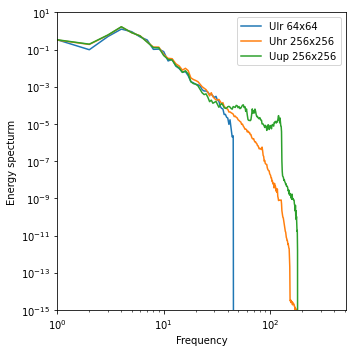

In [15]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.loglog(np.arange(len(phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]))), 
                         phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]), label='Ulr 64x64')
axs.loglog(np.arange(len(phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]), label='Uhr 256x256')
axs.loglog(np.arange(len(phy.powerspec(Uup.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uup.reshape(H,H,2)[:,:,0]), label='Uup 256x256')
axs.set_ylim(10**(-15), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.ylabel('Energy specturm')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

According to the Kolmogorov model (K41), the energy specturm of the 2D velocity field of the 2D turbulence flow should follow a particoular behaviour, know as the *-5/3 law*.

That is, at very high Reynold number (indicator of the turbulence of a flow), the slope of the energy spectrum (within the so called 'inertial subrange') has slope of $-5/3$.  
More formally, the inertial subrange the energy spectrum $E(k)$ of the turbulence must be of the form:

$$
E(k) = C \varepsilon_0^{2/3} k^{-5/3} \quad (l^{-1} \ll k \ll \eta^{-1})
$$
where:
- $C$ is a constant of the flow,
- $\varepsilon_0$ is the rate of energy dissipation,
- $\eta$ is the 'Kolmogorov's length', corresponding the minimum size after which we pass from self-similar turbulence to diffusion regime)
- $l$ is the 'energy-constating scale', correposding to the size of the biggest vortices.

We can see that the interepolation upsampling is adding information as it is increasing the bandwidth of the specrum (from the blue line, to the green one), however this information is not consistent with the physics. In fact, it should approximate the orange line. Everying which is above the orange line at high frequency is artificial noise.

## Deep Learning based upsampling (baseline 1)

We can levarange on the recent Deep Learning studies to build a model which can learn the intrisict physics 
from the data.

In particular, we can use the so called coordinate-based MLP model to estimate the function $f : \mathbf{x} \mapsto \mathbf{u}$.  
The state-of-the-art coord-MLP uses a simple MLP model whose input are first projected into random fourier features (RFF). This model is here denoted as RFFNet.  
A coord-based MLP learn to encode the training data as is overfitting them by construction.  
It can be show that this is equivalent to do kernel regression of the training data.  
The associated kernel learn by the MLP is know as Neural Tangent Kernel (NTK).  
The RFF is a trick (wellknow from Kernel regression) used to speed up convergence and accuracy.

At train model learn the map $f_LR : \mathbf{x}_{LR} \mapsto \mathbf{u}_{LR}$.  
At test time is able to evaluate $f(\mathbf{x}_{OF}$, where $\mathbf{x}_{OF}$ are off-grid points within the coase grid used for training.

In [16]:
import torch
from turboflow.models.rff import RFFNet
from turboflow.dataloaders import Turbo2D_simple
from torch.utils.data import Dataset, DataLoader

# set up cuda 
torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# model (RFF + MLP)
fft_scale = 10
fft_nfeat = 256
mlp_layers = [2*fft_nfeat] + [256]*3 + [2]

rffnet = RFFNet('RFFNet', mlp_layers, fft_nfeat, fft_scale)

# training data
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

# TRAIN!
rffnet.to(device)
rffnet.fit(trainloader, epochs=2000)

Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Epoch: 100, Loss: 0.001778
Epoch: 200, Loss: 0.000040
Epoch: 300, Loss: 0.000005
Epoch: 400, Loss: 0.000002
Epoch: 500, Loss: 0.000001
Epoch: 600, Loss: 0.000001
Epoch: 700, Loss: 0.000002
Epoch: 800, Loss: 0.000000
Epoch: 900, Loss: 0.000000
Epoch: 1000, Loss: 0.000000
Epoch: 1100, Loss: 0.000000
Epoch: 1200, Loss: 0.000000
Epoch: 1300, Loss: 0.000000
Epoch: 1400, Loss: 0.000003
Epoch: 1500, Loss: 0.000000
Epoch: 1600, Loss: 0.000000
Epoch: 1700, Loss: 0.000000
Epoch: 1800, Loss: 0.000000
Epoch: 1900, Loss: 0.000000
Epoch: 2000, Loss: 0.000000
Done with Training
Final error: 1.1192014426342212e-06


At test time we can run the model on a set of new off-grid point, for instance a meshgrid of HR resolution

(65536, 2)


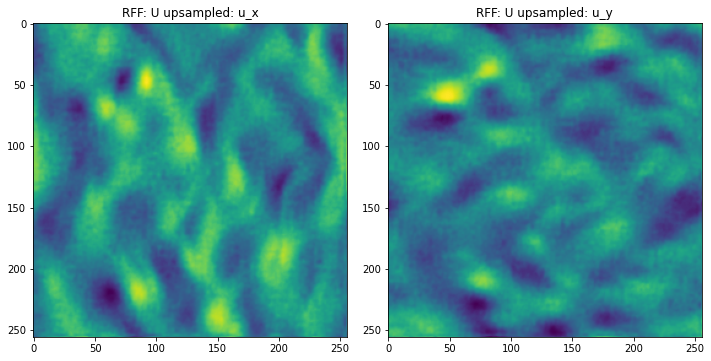

In [17]:
# TEST!
ngrid = H # high resolution dimension
coords = np.linspace(0, 1, ngrid)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp
coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().contiguous().to(device)

rffnet.eval().to(device)
pred = rffnet(x)
Urff = pred.cpu().detach().numpy().squeeze().reshape(H,H,2)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('RFF: U upsampled: u_x')
plt.imshow(Urff[:,:,0])
plt.subplot(122)
plt.title('RFF: U upsampled: u_y')
plt.imshow(Urff[:,:,1])
plt.tight_layout()
plt.show()

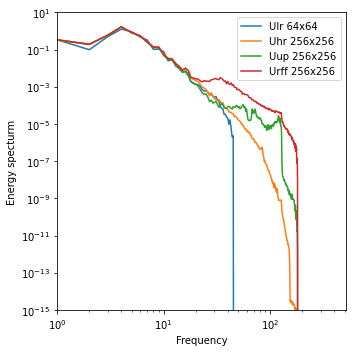

In [18]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.loglog(np.arange(len(phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]))), 
                         phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]), label='Ulr 64x64')
axs.loglog(np.arange(len(phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]), label='Uhr 256x256')
axs.loglog(np.arange(len(phy.powerspec(Uup.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uup.reshape(H,H,2)[:,:,0]), label='Uup 256x256')
axs.loglog(np.arange(len(phy.powerspec(Urff.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Urff.reshape(H,H,2)[:,:,0]), label='Urff 256x256')
axs.set_ylim(10**(-15), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.ylabel('Energy specturm')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

We can see that a coord-based MLP learned to upsample the image and allow for simple and fast off-grid evaluation at test time. However the images are not better than a simple interpolation and the physical constraint $\nabla \mathbf{u} = 0$  it is not respected, as we can see from the following results.

Warning *** CHECK THE GRADIENT DIRECTION


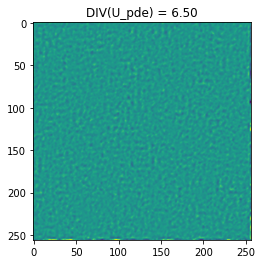

In [19]:
Dup = phy.compute_divergence(Urff[:,:,0], Urff[:,:,1])
plt.imshow(Dup)
plt.title('DIV(U_pde) = %1.2f' % np.linalg.norm(Dup))
plt.show()

## Physics-informed Deep Learning based upsampling (baseline 2)

A way to impose some physics-based constraint in the Neural Network is to follow the works on Physics-informed NN (PINN). PINN are used to solve PDE and in general the model are simple extension of coord-based MLP, where the loss function encode the PDE.

For instance we can add the $\nabla \mathbf{u} = 0$ to the MSE loss function, that is:

$$
\mathcal{L}_\theta = \| \hat{\mathbf{u}} - \mathbf{u} \|_2^2 + \lambda_\text{phy} \| \nabla \hat{\mathbf{u}} \|_2^2
$$

where $\hat{\mathbf{u}} = \mathtt{MLP}(\mathbf{x})$ and $\mathbf{u}$ is the ground truth.  
Notice that $\mathbf{u}$ is the low resolution 2D vector field. The HR image/field is never used.

In [20]:
from turboflow.models.phyrff_soft import PiRFFNet


# model (RFF + MLP)
fft_scale = 10
fft_nfeat = 256
mlp_layers = [2*fft_nfeat] + [256]*3 + [2]

pirffntet = PiRFFNet('RFFNet', mlp_layers, fft_nfeat, fft_scale)

# training data
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

# TRAIN!
pirffntet.to(device)
pirffntet.fit(trainloader, epochs=6000)

Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Epoch: 100, Loss: (0.027077 + 132.473114) = 0.040324
Epoch: 200, Loss: (0.003172 + 91.159424) = 0.012288
Epoch: 300, Loss: (0.001349 + 74.323837) = 0.008781
Epoch: 400, Loss: (0.000865 + 66.882469) = 0.007554
Epoch: 500, Loss: (0.000657 + 59.848587) = 0.006642
Epoch: 600, Loss: (0.000548 + 55.444157) = 0.006093
Epoch: 700, Loss: (0.000448 + 52.620556) = 0.005710
Epoch: 800, Loss: (0.000389 + 47.068199) = 0.005096
Epoch: 900, Loss: (0.000355 + 45.912704) = 0.004946
Epoch: 1000, Loss: (0.000323 + 43.128372) = 0.004636
Epoch: 1100, Loss: (0.000282 + 40.969261) = 0.004379
Epoch: 1200, Loss: (0.000267 + 39.026428) = 0.004170
Epoch: 1300, Loss: (0.000258 + 37.339565) = 0.003992
Epoch: 1400, Loss: (0.000231 + 35.000248) = 0.003731
Epoch: 1500, Loss: (0.000220 + 33.910889) = 0.003611
Epoch: 1600, Loss: (0.000210 + 33.6907

(65536, 2)


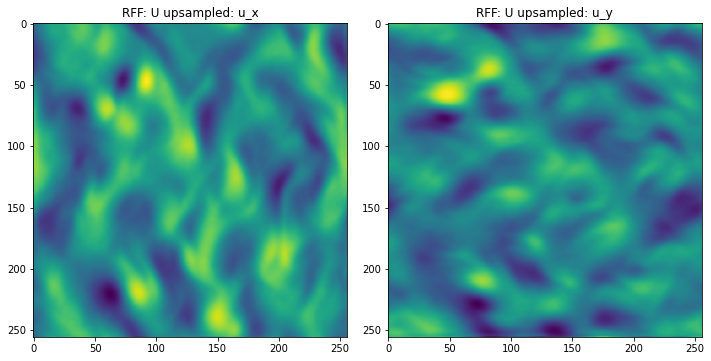

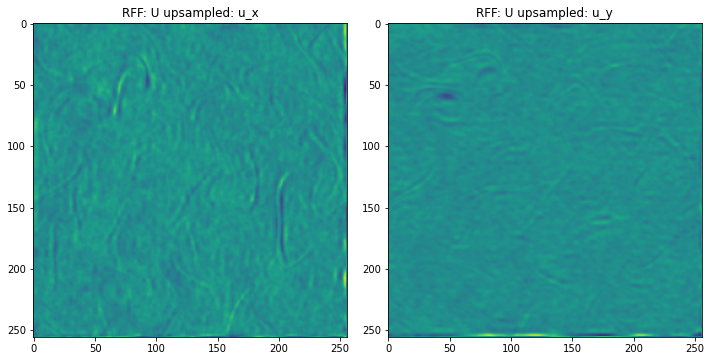

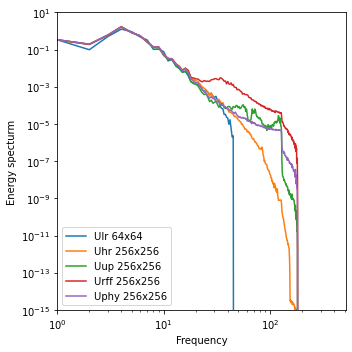

In [21]:
# TEST!
ngrid = H # high resolution dimension
coords = np.linspace(0, 1, ngrid)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp
coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().contiguous().to(device)

pirffntet.eval().to(device)
pred = pirffntet(x)
Uphy = pred.cpu().detach().numpy().squeeze().reshape(H,H,2)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('RFF: U upsampled: u_x')
plt.imshow(Uphy[:,:,0])
plt.subplot(122)
plt.title('RFF: U upsampled: u_y')
plt.imshow(Uphy[:,:,1])
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('RFF: U upsampled: u_x')
plt.imshow(Uphy[:,:,0] - Uhr.reshape(H,H,2)[:,:,0])
plt.subplot(122)
plt.title('RFF: U upsampled: u_y')
plt.imshow(Uphy[:,:,1] - Uhr.reshape(H,H,2)[:,:,1])
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.loglog(np.arange(len(phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]))), 
                         phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]), label='Ulr 64x64')
axs.loglog(np.arange(len(phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]), label='Uhr 256x256')
axs.loglog(np.arange(len(phy.powerspec(Uup.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uup.reshape(H,H,2)[:,:,0]), label='Uup 256x256')
axs.loglog(np.arange(len(phy.powerspec(Urff.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Urff.reshape(H,H,2)[:,:,0]), label='Urff 256x256')
axs.loglog(np.arange(len(phy.powerspec(Uphy.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uphy.reshape(H,H,2)[:,:,0]), label='Uphy 256x256')
axs.set_ylim(10**(-15), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.ylabel('Energy specturm')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

Warning *** CHECK THE GRADIENT DIRECTION


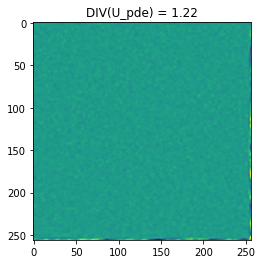

In [22]:
# check if it is divergence free
Dup = phy.compute_divergence(Uphy[:,:,0], Uphy[:,:,1])
plt.imshow(Dup)
plt.title('DIV(U_pde) = %1.2f' % np.linalg.norm(Dup))
plt.show()

## HOW TO IMPROVE

### Hard Constraint instead of Soft ones
Imposing $\nabla \mathbf{u} = 0$ in the loss function is called in the literature imposing *soft constraint*. The model is regularized by the minimizing such a penalty, but the constraint is not necesseraly satisfied at the a


### Off-grid regularization based on Structure Function (Self-similarity Functions)
So far at train time we used only the coordinates and the field at low resolution. While the high-resolution data are not accessible, some physical properties of the data can be used and tested on high-resolution coordinates. For instance, during training time, one can see the Energy spectrum of some random highly sampled patches and just evalutate how distant such curve is from the K41 model.  
However building a loss on the K41 model may be not trivial. A solution came from the so-called Structure functions, that are local statistics of the vector field, for which well studied model are available (coming from the Kolmogorov theory).

Structure function $S^p(d)$ are $n$-th order statistics of the velocity field function of the spatial increment $d$:
$$
S^p(d) = < ((\mathbf{u}(\mathbf{x} + d\mathbf{n}) - \mathbf{u}(\mathbf{x})) \cdot \mathbf{n})^p >
$$
where $p$ is the order of the statistics (typically 2 or 3) and $<\cdot>$ is the average over point in a given domain $| \Omega |$.

For a turbulent flow, the turbulent velocity field $\mathbf{u}$ must follow the following low
$$
S^2(d) \sim \beta d^2
$$
for $d \in [0, \eta]$, where $\eta$ is defined by the problem.


In [24]:
nx, ny = Uhr.reshape(H,H,2)[:,:,0].shape

U2h = np.concatenate([Uhr.reshape(H,H,2)]*2, axis=1)
print(U2h.shape)
U2v = np.concatenate([Uhr.reshape(H,H,2)]*2, axis=0)
print(U2v.shape)
U2d = np.concatenate([U2h, U2h], axis=0)
print(U2d.shape)

increments = np.arange(H)
sfun = np.zeros((H,3))

Uhr_sq = Uhr.reshape(H,H,2)

for d in increments:
    
    # horizontal axis 
    diff_h = (U2h[:,d:H+d,:] - Uhr_sq)**2
    diff_h = diff_h[1]
    
    # vertical axis 
    diff_v = (U2v[d:H+d,:,:] - Uhr_sq)**2
    diff_v = diff_v[0]
    
    # diagonal axis
    diff_d = (U2d[d:H+d,d:H+d,:] - Uhr_sq)**2
    diff_d = (diff_d[0]+diff_d[1])/2
    
    sfun[d,0] = diff_h.mean()
    sfun[d,1] = diff_v.mean()
    sfun[d,2] = diff_d.mean()
    

(256, 512, 2)
(512, 256, 2)
(512, 512, 2)


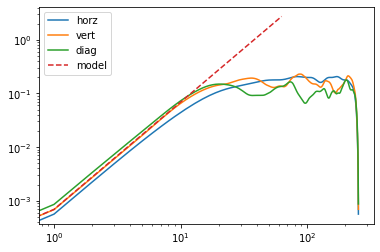

In [26]:
c = 0.25
plt.loglog(sfun[:,0], label='horz')
plt.loglog(sfun[:,1], label='vert')
plt.loglog(sfun[:,2], label='diag')
plt.loglog(np.arange(nx//4), c*0.00275*np.arange(nx//4)**2, '--', label='model')
plt.legend()
plt.show()

### Structure-function regularization

At training time, it is possible to evalute the structure function on the prediction of the MLP on off-grid data.

Let be the following quantities:

$\mathbf{x}_{LR} \in \mathcal{D}_{LR} = [0:\Delta_x:1]\times[0:\Delta_y:1] \subset \mathbb{Q}^2$ the low resolution input grid

$\mathbf{x}_{OF} \in \mathcal{D}_{OF} = [0,1]\times[0,1] \subset \mathbb{R}^2$ the off-grid data point

At training time, the network is optimize with the following loss function

$$
\mathcal{L}_\theta = \sum_i \| u_{LR}[i] - \mathtt{MLP}(\mathbf{x}_{LR}[i]) \|^2 
                   + \sum_i \| S^2(d, \mathtt{MLP}(\mathbf{x}_{OF}[i])) - \beta d^2 \|^2 
$$